In [7]:
from importlib.metadata import version
import torch

print("TORCH VERSION :", version("torch"))
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backend.mps.is_available() else "cpu"
)
# print("Device  : ", device.upper())

TORCH VERSION : 2.2.2


In [8]:
torch.manual_seed(123)
torch.cuda.manual_seed(123)

dtype = (
    "bfloat16"
    if torch.cuda.is_available() and torch.cuda.is_bf16_supported()
    else "float16"
)


torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

In [9]:
from torch import nn
import torch.nn.functional as F
from dataclasses import dataclass

In [10]:
from dataclasses import dataclass
import torch


@dataclass
class ModelArgs:
    vocab_size: int = 32000  # llama2 tokenizer has 32k vocab size
    emebdding_dim: int = 4096
    max_seq_len: int = 2048
    embedding_dropout: float = 0.0

    rms_norm_eps: float = 1e-05

    rope_scaling: float = 1.0
    rope_theta: float = 10000.0

    attention_bias: bool = False
    attention_dropout: float = 0.0
    num_attention_heads: int = 32
    num_key_value_heads: int = 32
    use_cache: bool = True
    use_sliding_window: bool = True
    residual_dropout: float = 0.1

    mlp_hidden_size: int = int(
        1.3 * emebdding_dim
    )  # set some lambda function or scaling factor
    mlp_dropout: float = 0.0

    num_layers: int = 32

    device: str = (
        "cuda"
        if torch.cuda.is_available()
        else "mps" if torch.backend.mps.is_available() else "cpu"
    )

In [11]:
from src.cells.position import RotaryEmbedding

In [12]:
class Attention(nn.Module):
    def __init__(self, args: ModelArgs):
        super().__init__()

        args.num_attention_heads % args.num_key_value_heads == 0, "Head counts should be divisible KV Heads counts"
        self.group_factor = args.num_attention_heads // args.num_key_value_heads
        self.head_dim = args.emebdding_dim // args.num_attention_heads

        self.wq = nn.Linear(
            args.emebdding_dim, args.emebdding_dim, bias=args.attention_bias
        )
        self.wk = nn.Linear(
            args.emebdding_dim,
            args.emebdding_dim // self.group_factor,
            bias=args.attention_bias,
        )
        self.wv = nn.Linear(
            args.emebdding_dim,
            args.emebdding_dim // self.group_factor,
            bias=args.attention_bias,
        )
        self.wo = nn.Linear(
            args.emebdding_dim, args.emebdding_dim, bias=args.attention_bias
        )

        self.dropout = args.attention_dropout
        self.residual_dropout = nn.Dropout(args.residual_dropout)

    def forward(
        self, x: torch.Tensor, rope_q: RotaryEmbedding, rope_k: RotaryEmbedding
    ):
        b, seqlen, _ = x.shape
        # QKV
        xq, xk, xv = (
            self.wq(x).view(b, seqlen, -1, self.head_dim),
            self.wk(x).view(b, seqlen, -1, self.head_dim),
            self.wv(x).view(b, seqlen, -1, self.head_dim),
        )
        # RoPE on Q,K
        xq = rope_q(xq).transpose(1, 2)
        xk = rope_k(xk).transpose(1, 2)

        xv = xv.transpose(1, 2)
        if hasattr(F, "scaled_dot_product_attention"):
            output = F.scaled_dot_product_attention(
                xq,
                xk,
                xv,
                attn_mask=None,
                dropout_p=self.dropout if self.training else 0.0,
                is_causal=True,
            )
        else:
            raise NotImplemented("Upgrade to pytorch version >= 2.0")

        # restore time as batch dimension and concat heads
        output = output.transpose(1, 2).contiguous().view(b, seqlen, -1)
        return self.residual_dropout(self.wo(output))

In [13]:
# config = ModelArgs()
# model = Attention(config)
# model = model.to(device)

In [14]:
# x = torch.rand(8,2048,4096,device=device)
# model(x).shape

In [15]:
import torch
import torch.nn as nn

from src.cells.normalization import RMSLayerNorm
from src.cells.attention import GQMultiHeadAttention
from src.cells.feedforward import FeedForward


class Block(nn.Module):
    def __init__(self, args) -> None:
        super().__init__()

        self.norms = RMSLayerNorm(args.emebdding_dim, eps=args.rms_norm_eps)
        self.attention = GQMultiHeadAttention(args)
        self.mlp = FeedForward(
            args.emebdding_dim, args.mlp_hidden_size, dropout=args.mlp_dropout
        )

    def forward(self, x, rope_q, rope_k):
        x = x + self.attention(self.norms(x), rope_q, rope_k)
        x = x + self.mlp(self.norms(x))
        return x

In [16]:
# # Sanity - should be of same size as input
# Block(config).to(device)(x).shape

In [17]:
import torch
from torch import nn
import torch.nn.functional as F
import math

from src.models.blm.config import ModelArgs
from src.models.blm.block import Block

from src.cells.normalization import RMSLayerNorm
from typing import Optional
from src.cells.position import RotaryEmbedding


class Transformer(nn.Module):
    def __init__(self, args: ModelArgs):
        super().__init__()

        self.tok_embd = nn.Embedding(args.vocab_size, args.emebdding_dim)
        self.dropout = nn.Dropout(args.embedding_dropout)
        head_dim = args.emebdding_dim // args.num_attention_heads
        q_kv_factor = args.num_attention_heads // args.num_key_value_heads
        self.rope_q = RotaryEmbedding(
            head_dim,
            args.max_seq_len,
            device=args.device,
        )
        self.rope_k = RotaryEmbedding(
            head_dim // q_kv_factor,
            args.max_seq_len,
            device=args.device,
        )

        # Freeze the parameters rope_q and rope_k
        self.rope_q.requires_grad_(False)
        self.rope_k.requires_grad_(False)

        self.layers = nn.ModuleList([Block(args) for lid in range(args.num_layers)])

        self.norm = RMSLayerNorm(args.emebdding_dim, eps=args.rms_norm_eps)
        self.output = nn.Linear(args.emebdding_dim, args.vocab_size, bias=False)

        # share the unembedding parameters with the embedding parameters
        self.tok_embd.weight = (
            self.output.weight
        )  # https://paperswithcode.com/method/weight-tying

        # init all weights
        self.apply(self._init_weights)
        # apply special scaled init to the residual projections, per GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith("wo.weight"):
                torch.nn.init.normal_(
                    p, mean=0.0, std=0.02 / math.sqrt(2 * args.num_layers)
                )

    def __repr__(self):
        return f"{self.get_num_params()} Million Params Model"

    def get_num_params(self, non_embedding=True):
        """
        Return the number of parameters in the model.
        For non-embedding count (default), the position embeddings get subtracted.
        The token embeddings would too, except due to the parameter sharing these
        params are actually used as weights in the final layer, so we include them.
        """
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.tok_embd.weight.numel()
        return n_params / 1e6  # In Million

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(
        self, tokens: torch.Tensor, targets: Optional[torch.Tensor] = None
    ) -> torch.Tensor:
        x = self.dropout(self.tok_embd(tokens))
        for layer in self.layers:
            x = layer(
                x, self.rope_q, self.rope_k
            )  ## How about we add residual connection here also ?
        x = self.norm(x)

        loss = None
        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.output(x)
            loss = F.cross_entropy(
                logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1
            )
        else:
            # inference-time mini-optimization: only forward the output on the very last position
            logits = self.output(
                x[:, [-1], :]
            )  # note: using list [-1] to preserve the time dim
        return logits, loss

In [18]:
conf = {
    "vocab_size": 32000,
    "emebdding_dim": 64,
    "max_seq_len": 512,
    "embedding_dropout": 0.0,
    "rms_norm_eps": 1e-05,
    "rope_scaling": 1.0,
    "rope_theta": 10000.0,
    "attention_bias": False,
    "attention_dropout": 0.0,
    "num_attention_heads": 8,
    "num_key_value_heads": 4,
    "use_cache": True,
    "use_sliding_window": True,
    "residual_dropout": 0.1,
    "mlp_dropout": 0.0,
    "mlp_hidden_size": int(1.3 * 64),
    "num_layers": 5,
    "device": "cuda",
}

In [19]:
config = ModelArgs(**conf)
model1 = Transformer(config)
model1.to(device)

0.115679 Million Params Model

In [38]:
x = torch.randint(0, 64, (8, 64), device=device)
model(x)[0].shape

torch.Size([1, 32000])

In [1]:
from datasets import load_dataset, concatenate_datasets, load_from_disk
BASE_URL = "/home/pranav-pc/projects/OpenTransformer/multiformer/"
data = load_from_disk(BASE_URL + "data/interim/TinyStories.hf")

In [5]:
data = data.map(lambda example : {'count':len(example['idx'])})

Map:   0%|          | 0/2141709 [00:00<?, ? examples/s]

<Axes: ylabel='Count'>

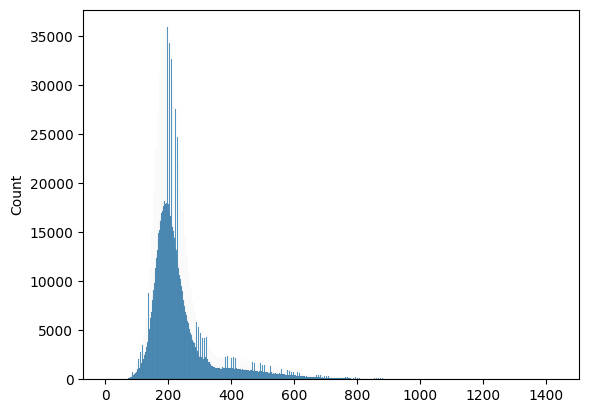

In [9]:
import seaborn as sns
sns.histplot(data['count']);

In [18]:
768/8

96.0

In [31]:
import torch
torch.randn(1,)

tensor([0.1316])